In [2]:
# The indoor recordings of German data is added
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as L, models as M, callbacks as C, optimizers as O
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc

In [3]:
# =========================
#           PATHS
# =========================
# Each of these is a TOP-LEVEL folder that contains 4–5 (or more) subfolders of .npy files.
DRONE_ROOT   = r"/home/destrox-907/Husnian_FYP/Dataset/MFCC Drone Dataset/MFCC Drone Dataset"
NODRONE_ROOT = r"/home/destrox-907/Husnian_FYP/Dataset/MFCC Noise Dataset/MFCC Noise Dataset"

# =========================
#      CONFIG / HYPERS
# =========================
INPUT_SHAPE     = (13, 40, 1)
BATCH_SIZE      = 128
EPOCHS          = 40
LEARNING_RATE   = 1e-3
MIXUP_ALPHA     = 0.3      # set 0.0 to disable
USE_SPECAUG     = True
VAL_SIZE        = 0.20
SEED            = 42

In [4]:
# =========================
#  RECURSIVE DATA LOADING
# =========================
def collect_npy_paths(root_dir):
    paths = []
    for r, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(".npy"):
                paths.append(os.path.join(r, f))
    return paths

def load_paths_and_labels(drone_root, nodrone_root):
    drone_paths   = collect_npy_paths(drone_root)
    nodrone_paths = collect_npy_paths(nodrone_root)
    paths  = np.array(drone_paths + nodrone_paths)
    labels = np.array([1]*len(drone_paths) + [0]*len(nodrone_paths), dtype=np.int32)
    return paths, labels

paths, labels = load_paths_and_labels(DRONE_ROOT, NODRONE_ROOT)
print(f"Total .npy files: {len(paths)} | drone={labels.sum()} | no_drone={len(labels)-labels.sum()}")

# Stratified split (replace with grouped split later if you want “unseen drone models” eval)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    paths, labels, test_size=VAL_SIZE, random_state=SEED, stratify=labels
)

Total .npy files: 349753 | drone=227124 | no_drone=122629


In [5]:
# =========================
#     DATA PIPELINE
# =========================
def npy_loader(path):
    try:
        arr = np.load(path.decode("utf-8")).astype("float32")
        # Force correct shape (13,40,1)
        arr = np.reshape(arr, (13, 40, 1))
        return arr
    except Exception as e:
        print(f"[WARN] Failed to load {path.decode('utf-8')}: {e}")
        # return a dummy all-zeros MFCC (will not harm training much)
        return np.zeros((13, 40, 1), dtype="float32")


def tf_load(path, label, training=True):
    x = tf.numpy_function(npy_loader, [path], Tout=tf.float32)
    x = tf.ensure_shape(x, INPUT_SHAPE)

    if training and USE_SPECAUG:
        def _specaug(a):
            a = a.copy()
            f_dim, t_dim, _ = a.shape  # 13,40,1
            # freq masks (light)
            for _ in range(2):
                f = np.random.randint(0, 3+1)
                f0 = np.random.randint(0, max(1, f_dim - f + 1))
                a[f0:f0+f, :, :] = 0.0
            # time masks (light)
            for _ in range(2):
                t = np.random.randint(0, 6+1)
                t0 = np.random.randint(0, max(1, t_dim - t + 1))
                a[:, t0:t0+t, :] = 0.0
            return a
        x = tf.numpy_function(_specaug, [x], Tout=tf.float32)
        x = tf.ensure_shape(x, INPUT_SHAPE)

    y = tf.one_hot(label, 2)
    return x, y

def make_dataset(paths, labels, batch=BATCH_SIZE, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(8192, reshuffle_each_iteration=True)
    ds = ds.map(lambda p, l: tf_load(p, l, training=training),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch)

    # Optional MixUp
    if training and MIXUP_ALPHA > 0.0:
        def mixup_batch(x, y):
            lam = tf.random.uniform([], 0.5, 1.0)  # gentle mix
            idx = tf.random.shuffle(tf.range(tf.shape(x)[0]))
            x2 = tf.gather(x, idx); y2 = tf.gather(y, idx)
            return lam*x + (1-lam)*x2, lam*y + (1-lam)*y2
        ds = ds.map(mixup_batch, num_parallel_calls=tf.data.AUTOTUNE)

    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(X_train, y_train, training=True)
val_ds   = make_dataset(X_val,   y_val,   training=False)


I0000 00:00:1757475994.846852   11394 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 870 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1757475994.848152   11394 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21759 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:05:00.0, compute capability: 8.9


In [6]:
# =========================
#   RESNET-LIKE BACKBONE
# =========================
def res_block(x, filters, stride=1):
    shortcut = x
    x = L.Conv2D(filters, (3,3), strides=stride, padding="same", use_bias=False)(x)
    x = L.BatchNormalization()(x); x = L.ReLU()(x)
    x = L.Conv2D(filters, (3,3), padding="same", use_bias=False)(x)
    x = L.BatchNormalization()(x)
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = L.Conv2D(filters, (1,1), strides=stride, padding="same", use_bias=False)(shortcut)
        shortcut = L.BatchNormalization()(shortcut)
    x = L.Add()([x, shortcut]); x = L.ReLU()(x)
    return x

def build_model(input_shape=(13,40,1), num_classes=2):
    inp = L.Input(shape=input_shape)
    x = L.Conv2D(32, (3,3), padding="same", use_bias=False)(inp)
    x = L.BatchNormalization()(x); x = L.ReLU()(x)

    x = res_block(x, 32)                 # 13x40
    x = res_block(x, 32)                 # 13x40
    x = L.MaxPool2D(pool_size=(1,2))(x)  # 13x20

    x = res_block(x, 64, stride=2)       # downsample
    x = res_block(x, 64)

    x = L.GlobalAveragePooling2D()(x)
    x = L.Dense(128, activation="relu")(x)
    x = L.Dropout(0.3)(x)
    out = L.Dense(num_classes, activation="softmax")(x)
    return M.Model(inp, out)

model = build_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 13, 40,    │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 13, 40,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 13, 40,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 13, 40,    │      9,216 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 40,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 13, 40,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 40,    │      9,216 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 40,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 13, 40,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 13, 40,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 13, 40,    │      9,216 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 40,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 13, 40,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 13, 40,    │      9,216 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 40,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 13, 40,    │          0 │ batch_normalizat

 Total params: 178,722 (698.13 KB)

 Trainable params: 177,762 (694.38 KB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
# =========================
#      TRAIN & EVAL
# =========================
opt = O.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

cbs = [
    C.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1),
    C.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    C.ModelCheckpoint("drone_resnet_best.keras", monitor="val_accuracy", save_best_only=True)
]


history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cbs)
# AUROC + best-F1 threshold
probs = model.predict(val_ds)[:, 1]
y_true = np.concatenate([y.numpy() for _, y in val_ds])[:, 1]
from sklearn.metrics import precision_recall_curve, auc, f1_score
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(y_true, probs)
prec, rec, thr = precision_recall_curve(y_true, probs)
auprc = auc(rec, prec)
cands = np.linspace(0.05, 0.95, 19)
f1s = [f1_score(y_true, (probs >= t).astype(int)) for t in cands]
best_thr, best_f1 = cands[int(np.argmax(f1s))], max(f1s)

Epoch 1/40


2025-09-10 08:46:43.249979: I external/local_xla/xla/service/service.cc:163] XLA service 0x739f7401b570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-10 08:46:43.249997: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-09-10 08:46:43.250001: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-09-10 08:46:43.847511: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-10 08:46:44.151988: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-09-10 08:46:44.267519: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints

  17/2186 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.6441 - loss: 0.6405

I0000 00:00:1757476006.646178   19489 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2183/2186 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8659 - loss: 0.3924

2025-09-10 08:48:00.886067: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-10 08:48:00.886101: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-10 08:48:00.886107: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-10 08:48:01.118956: I external/l

2186/2186 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8659 - loss: 0.3924

2025-09-10 08:48:11.464062: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-10 08:48:11.551277: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_290', 8 bytes spill stores, 8 bytes spill loads

2025-09-10 08:48:11.837464: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_290', 576 bytes spill stores, 576 bytes spill loads



2186/2186 ━━━━━━━━━━━━━━━━━━━━ 91s 39ms/step - accuracy: 0.8895 - loss: 0.3652 - val_accuracy: 0.9322 - val_loss: 0.1683 - learning_rate: 0.0010
Epoch 2/40
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 81s 37ms/step - accuracy: 0.9088 - loss: 0.3380 - val_accuracy: 0.9652 - val_loss: 0.1150 - learning_rate: 0.0010
Epoch 3/40
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 85s 39ms/step - accuracy: 0.9150 - loss: 0.3293 - val_accuracy: 0.9724 - val_loss: 0.1045 - learning_rate: 0.0010
Epoch 4/40
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.9202 - loss: 0.3199 - val_accuracy: 0.9790 - val_loss: 0.0916 - learning_rate: 0.0010
Epoch 5/40
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.9253 - loss: 0.3122 - val_accuracy: 0.9798 - val_loss: 0.0928 - learning_rate: 0.0010
Epoch 6/40
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 86s 39ms/step - accuracy: 0.9252 - loss: 0.3140 - val_accuracy: 0.9692 - val_loss: 0.1001 - learning_rate: 0.0010
Epoch 7/40
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 87s 40ms/step - accuracy: 0.9274 

2025-09-10 09:19:52.200864: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# --- SAVE THE FINAL MODEL (whatever weights are in memory now) ---
model.save("drone_resnet_data_01.keras")

In [9]:

print(f"\n=== Validation Metrics ===")
print(f"AUROC  : {auroc:.4f}")
print(f"AUPRC  : {auprc:.4f}")
print(f"Best F1: {best_f1:.4f} @ threshold={best_thr:.2f}")


=== Validation Metrics ===
AUROC  : 0.9991
AUPRC  : 0.9996
Best F1: 0.9931 @ threshold=0.35


Confusion Matrix (rows=true, cols=pred):
[[24270   256]
 [  374 45051]]


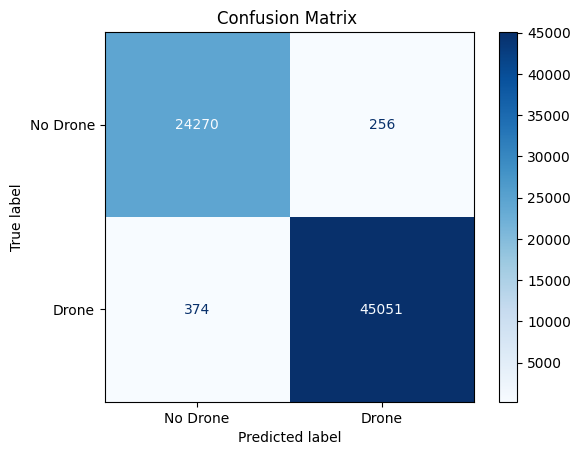


Classification Report:
              precision    recall  f1-score   support

    No Drone       0.98      0.99      0.99     24526
       Drone       0.99      0.99      0.99     45425

    accuracy                           0.99     69951
   macro avg       0.99      0.99      0.99     69951
weighted avg       0.99      0.99      0.99     69951



In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Convert probabilities into predicted labels using best threshold
y_pred = (probs >= best_thr).astype(int)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

# Plot with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Drone", "Drone"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title(f"Confusion Matrix ")
plt.show()

# Extra: precision, recall, F1 per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["No Drone", "Drone"]))
